In [1]:
import pyds9
import glob
import astropy.io.fits
import numpy as np
import astropy.time as astt
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
#ds9=pyds9.DS9()
inputlist=glob.glob('CetII/*.fz')

In [8]:

matches = {'reference': None}
max = 0
dateobs = []
for ff in inputlist[0:]:
    hdu = astropy.io.fits.open(ff)
    phottable = hdu['CAT'].data
    dateobs.append (astt.Time(hdu['SCI'].header['DATE-OBS'], scale='utc', format='isot').to_datetime())

    matches[ff] = phottable
    if phottable['X'].size > max:
        max = phottable['X'].size
        matches['reference'] = ff
   
refcoordinates = SkyCoord (ra = matches[matches['reference']]['RA'] * u.degree, 
                  dec = matches[matches['reference']]['DEC'] * u.degree)

dateobs = np.asarray(dateobs)
mags = []

for image in matches:
    if image == 'reference':
        continue
    imagecoordiantes = SkyCoord (ra = matches[image]['RA'] * u.degree, 
                  dec = matches[image]['DEC'] * u.degree)
    idx, d2d,d3d = refcoordinates.match_to_catalog_sky(imagecoordiantes)
    matches[image] = np.transpose(np.transpose(matches[image])[idx])
    distance = refcoordinates.separation (imagecoordiantes[idx]).arcsecond
    matches[image]['FLUX'][distance>5] = 0 # force a nan or so down below
    mags.append (-2.5*np.log10(matches[image]['FLUX'] / 600) + 22.835)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


[ 0.         -0.04224195 -0.06182528 -0.08417239 -0.04803745 -0.0407618
  0.00273865 -0.06008953 -0.07064779 -0.04482338 -0.03466832 -0.05573518
 -0.07095993 -0.08070699  0.10133434 -0.05755125 -0.06987068  0.01546173
 -0.04687451 -0.05040905 -0.04998395 -0.00339359 -0.06374091  0.15113473
 -0.07103479 -0.04145655  0.05231072 -0.04535891 -0.04424694 -0.05691888
 -0.01709823 -0.04498613 -0.02418822 -0.05936973 -0.08198435 -0.09088356
 -0.06130754 -0.00476109 -0.07112637 -0.07772987  0.00212044 -0.06754636
 -0.01359049 -0.08114339 -0.069043   -0.03774836 -0.07585279 -0.00733348
 -0.04820826 -0.04879007 -0.03837921 -0.07858344 -0.08168309 -0.00480236
 -0.01204339 -0.07494722 -0.07024729 -0.0397383  -0.08323734 -0.07385379
 -0.08145167 -0.07274207 -0.05162654 -0.07621178 -0.04787537 -0.05984299
 -0.09576386 -0.09108455 -0.0197764  -0.01828737 -0.00579895 -0.01322068
 -0.07953796 -0.07585489 -0.05928194 -0.06926313 -0.02157911 -0.07025078
 -0.0598613   0.05902296 -0.08154326 -0.05766223 -0.

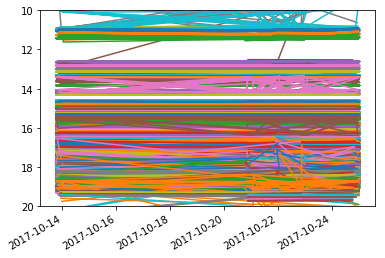

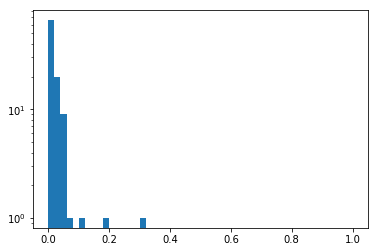

IndexError: boolean index did not match indexed array along dimension 1; dimension is 99 but corresponding boolean dimension is 315

In [9]:
mags = np.asarray(mags)
# find good reference stars to calculate corrections
smags = mags[:, np.isfinite (np.sum(mags,0))]
magavg = np.mean (smags,0)
corrections = np.log10 (np.median (10 **smags[:, np.less (magavg, 16) & np.greater(magavg,12)], 1))
corrections -= corrections[0]
print corrections

#show all corrected light curves
for ii in range (mags.shape[0]):
    
    mags[ii,:] -= corrections[ii]
    
plt.plot (dateobs, mags)
plt.gcf().autofmt_xdate()
plt.ylim([20,10])
plt.show()

# find variable stars
mags[np.isinf(mags)]=1000
rms = np.nanstd (mags, 0)
plt.hist (rms, range=[0,1], bins=50, log=True)
plt.show()

variable = np.greater(rms,0.1) & np.less (rms,1)

variableMags = smags[0,variable]
print variableMags

for idx in matches:
    
    print idx, matches[idx][variable]
    break

plt.plot (dateobs, mags[:,variable], '.')
plt.gcf().autofmt_xdate()
plt.ylim([20,14])
plt.show()
